In [84]:
import matplotlib.pyplot as plt
import numpy as np

In [85]:
from enum import Enum

class ActionPS(Enum):
    LEAVE = 0
    STAY = 1

    def __str__(self):
        return ["Leave", "Stay"][self.value]

class ActionPD(Enum):
    DEFECT = 0
    COOPERATE = 1

    def __str__(self):
        return ["Defect", "Cooperate"][self.value]

class State(Enum):
    PARTNER_DEFECTED = 0
    PARTNER_COOPERATED = 1

    def __str__(self):
        return ["Partner Defected", "Partner Cooperated"][self.value]
    
def get_state(action: ActionPD) -> State:
    return State.PARTNER_COOPERATED if action == ActionPD.COOPERATE else State.PARTNER_DEFECTED

In [86]:
class StrategyPS(Enum):
    ALWAYS_STAY = 0
    OUT_FOR_TAT = 1
    REVERSE_OUT_FOR_TAT = 2
    ALWAYS_LEAVE = 3
    RANDOM = 4

    def __str__(self):
        return ['Always-Stay', 'Out-For-Tat', 'Reverse-OFT', 'Always-Leave', 'Random (PS)'][self.value]

    def color(self):
        return ['lightcoral', 'lightsteelblue', 'lightgreen', 'tan', 'mediumpurple'][self.value]
    
class StrategyPD(Enum):
    ALWAYS_COOPERATE = 0
    TIT_FOR_TAT = 1
    REVERSE_TIT_FOR_TAT = 2
    ALWAYS_DEFECT = 3
    RANDOM = 4
    
    def __str__(self):
        return ['Always-Cooperate', 'Tit-For-Tat', 'Reverse-TFT', 'Always-Defect', 'Random (PD)'][self.value]

    def color(self):
        return ['red', 'blue', 'green', 'yellow', 'purple'][self.value]

In [87]:
# returns the probabilities of selection actions given the current state 
def boltzmann_exploration(q_table, state: State, temperature: float) -> np.ndarray:
    exp = np.exp((q_table[state.value, :] - max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

def epsilon_greedy(q_table, state: State, epsilon: float) -> np.ndarray:
    if np.random.rand() < epsilon:
        return np.ones(len(q_table[state.value, :])) / len(q_table[state.value, :])
    else:
        prob = np.zeros(len(q_table[state.value, :]))
        prob[np.argmax(q_table[state.value, :])] = 1
        return prob

In [88]:
# runs the Q-Learning algorithm on the provided qtable
# NOTE: alpha is the learning rate and gamma is the discount rate
def q_learning(qtable, state: State, action, reward: float, new_state: State, 
               alpha: float, gamma: float, next_qtable = None) -> None:
    if next_qtable is None:
        next_qtable = qtable
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(next_qtable[new_state.value, :]))

In [89]:
class Trajectory:
    def __init__(self, state, action, reward, new_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.new_state = new_state

class Trajectories:
    def __init__(self):
        self.data = []
        
    def __iter__(self):
        i: int = 0
        while i + 1 < len(self.data):
            yield Trajectory(self.data[i], self.data[i + 1], self.data[i + 2], self.data[i + 3])
            i += 3

    def append(self, state, action, reward, new_state):
        if len(self.data) == 0:
            self.data.extend([state, action, reward, new_state])
        elif self.data[-1] != state:
            raise ValueError("Last recorded state is not equal to argument")
        
        self.data.extend([action, reward, new_state])
            

In [90]:
class Agent:
    def __init__(self, alpha: float, gamma: float, temp: float, 
                 last_action: ActionPD = None, qtable_ps = None, qtable_pd = None, tag = None):
        self.a = alpha
        self.t = temp
        self.g = gamma
        self.last_action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], 1) if last_action == None else last_action
        self.qtable_ps = np.zeros((2, 2)) if qtable_ps is None else np.copy(qtable_ps)
        self.qtable_pd = np.zeros((2, 2)) if qtable_pd is None else np.copy(qtable_pd)
        self.tag = tag
        
    # returns an action given the current state
    def get_action_ps(self, state: State, debug = False) -> ActionPS:
        temp = boltzmann_exploration(self.qtable_ps, state, self.t)
        action = np.random.choice([ActionPS.LEAVE, ActionPS.STAY], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action

    def get_action_pd(self, state: State, debug = False) -> ActionPD:
        temp = boltzmann_exploration(self.qtable_pd, state, self.t)
        action = np.random.choice([ActionPD.DEFECT, ActionPD.COOPERATE], p=temp)
        if debug:
            print("Action Probabilities: " + str(temp))
            print("Chosen Action: " + str(action))
        return action
    
    def update_reward(self, reward):
        pass
    
    # trains using trajectories from each round
    def train(self, trajectories, debug = False):
        # def sort_cooperate(t):
        #     return int(t[4] == ActionPD.DEFECT)

        # trajectories.sort(key=sort_cooperate)
        
        for trajectory in trajectories:
            # partner selection training
            q_learning(self.qtable_ps, trajectory[0], trajectory[1], trajectory[2], trajectory[3], self.a, self.g, next_qtable=self.qtable_pd)
            if debug:
                print(trajectory)
                print(self.qtable_ps)
            # prisoner's dilemma training
            q_learning(self.qtable_pd, trajectory[3], trajectory[4], trajectory[6], trajectory[5], self.a, self.g, next_qtable=self.qtable_ps)
            if debug:
                print(self.qtable_pd)
                print()
        # decrease temperature
        # self.t *= 0.01
    
    def get_strategy_ps(self):
        if (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_STAY
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] < self.qtable_ps[1, 1]):
            return StrategyPS.OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] < self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.REVERSE_OUT_FOR_TAT
        elif (self.qtable_ps[0, 0] > self.qtable_ps[0, 1] and self.qtable_ps[1, 0] > self.qtable_ps[1, 1]):
            return StrategyPS.ALWAYS_LEAVE
        else:
            return StrategyPS.RANDOM

    def get_strategy_pd(self):
        if (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_COOPERATE
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] < self.qtable_pd[1, 1]):
            return StrategyPD.TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] < self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.REVERSE_TIT_FOR_TAT
        elif (self.qtable_pd[0, 0] > self.qtable_pd[0, 1] and self.qtable_pd[1, 0] > self.qtable_pd[1, 1]):
            return StrategyPD.ALWAYS_DEFECT
        else:
            return StrategyPD.RANDOM
    


In [91]:
# returns the rewards of two agents in the prisoner's dilemma game
def prisoners_dilemma(a_i: ActionPD, a_j: ActionPD) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

In [92]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    if (population % 2 != 0):
        print("sdoo: population must be a multiple of two")
        return
    
    recorded_outcomes_pd = {
        (ActionPD.DEFECT, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.DEFECT, ActionPD.COOPERATE): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.COOPERATE): [0 for _ in range(episodes)],
    }

    recorded_agent_strategy_pairings = {
        # (a, b): [0 for _ in range(episodes)] for a in StrategyPD for b in StrategyPD
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_COOPERATE): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_COOPERATE, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_DEFECT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_DEFECT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        # (StrategyPD.RANDOM, StrategyPD.RANDOM): [0 for _ in range(episodes)],
    }

    recorded_outcome_changes = {
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],
    }

    agent_qvales_ps = [[0 for _ in range(episodes)] for _ in range(4)]
    agent_qvales_pd = [[0 for _ in range(episodes)] for _ in range(4)]

    recorded_qvalues_ps = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]
    recorded_qvalues_pd = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]

    agent_ps_actions_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]
    percentage_of_states_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]

    agent_chosen_switches_per_episode = [0 for _ in range(episodes)]
    agent_switches_per_episode = [0 for _ in range(episodes)]

    total_reward = [0 for _ in range(episodes)]

    # np.random.seed(0)

    # Global Q-Table Test
    # qtable_ps = np.zeros((2, 2))
    # qtable_pd = np.zeros((2, 2))
    # agents = [Agent(learning_rate, temperature, discount_rate, qtable_ps=qtable_ps, qtable_pd=qtable_pd) for _ in range(population)]
    availiable_tags = list(range((int)(population / 4)))
    availiable_tags = list(np.tile(availiable_tags, 4))

    agents = [Agent(learning_rate, temperature, discount_rate, 
                    tag=availiable_tags.pop(np.random.randint(0, len(availiable_tags)))) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        matching_tags = list(filter(lambda x: agents[x].tag == agents[i].tag, unpaired))
        if len(matching_tags) == 0:
            pass
        j = np.random.choice(matching_tags)
        unpaired.remove(j)
        pairs.append((i, j))

    
    for episode in range(episodes):
        # Record agent Q-Values
        for agent_idx in range(len(recorded_qvalues_ps)):
            for idx in range(len(recorded_qvalues_ps[agent_idx])):
                recorded_qvalues_ps[agent_idx][idx][episode] = agents[agent_idx].qtable_ps.ravel()[idx]

        for agent_idx in range(len(recorded_qvalues_pd)):
            for idx in range(len(recorded_qvalues_pd[agent_idx])):
                recorded_qvalues_pd[agent_idx][idx][episode] = agents[agent_idx].qtable_pd.ravel()[idx]


        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[s_i.value][episode] += 1
                percentage_of_states_per_episode[s_j.value][episode] += 1

                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)
                if a_i == ActionPS.LEAVE or a_j == ActionPS.LEAVE:
                    unpaired.append(i)
                    unpaired.append(j)
                    agent_switches_per_episode[episode] += 2
                    agent_chosen_switches_per_episode[episode] += int(a_i == ActionPS.LEAVE) + int(a_j == ActionPS.LEAVE)
                else:
                    temp_pairs.append((i, j))

                # r_i = 1 if a_j == ActionPS.STAY else -1
                # r_j = 1 if a_i == ActionPS.STAY else -1
                r_i = 0
                r_j = 0
                
                trajectories[i].append((s_i, a_i, r_i))
                trajectories[j].append((s_j, a_j, r_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                matching_tags = list(filter(lambda x: agents[x].tag == agents[i].tag, unpaired))
                if len(matching_tags) == 0:
                    pass
                j = np.random.choice(matching_tags)
                unpaired.remove(j)
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                strategy_i = agents[i].get_strategy_pd()
                strategy_j = agents[j].get_strategy_pd()
                if (strategy_i, strategy_j) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_i, strategy_j)][episode] += 1
                elif (strategy_j, strategy_i) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_j, strategy_i)][episode] += 1

                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[(s_i.value) + 2][episode] += 1
                percentage_of_states_per_episode[(s_j.value) + 2][episode] += 1

                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                total_reward[episode] += r_i + r_j
                
                ns_i = get_state(a_j)
                ns_j = get_state(a_i)
                recorded_outcomes_pd[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j


                # Record Trajectories
                t = trajectories[i][round]
                trajectories[i][round] = (t[0], t[1], t[2], s_i, a_i, ns_i, r_i)
                t = trajectories[j][round]
                trajectories[j][round] = (t[0], t[1], t[2], s_j, a_j, ns_j, r_j)

                # Record Actions taken
                agent_ps_actions_per_episode[2 * (s_i.value - 2) + a_i.value][episode] += 1
                agent_ps_actions_per_episode[2 * (s_j.value - 2) + a_j.value][episode] += 1

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            # agent.train(trajectories[idx], debug=(idx == 0))

        for idx in range(len(agent_qvales_ps)):
            agent_qvales_ps[idx][episode] = np.sum([agent.qtable_ps.ravel()[idx] for agent in agents]) / len(agents)

        for idx in range(len(agent_qvales_pd)):
            agent_qvales_pd[idx][episode] = np.sum([agent.qtable_pd.ravel()[idx] for agent in agents]) / len(agents)

        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)

        agent_ps_actions_per_episode[0][episode] /= (rounds * population)
        agent_ps_actions_per_episode[1][episode] /= (rounds * population)
        agent_ps_actions_per_episode[2][episode] /= (rounds * population)
        agent_ps_actions_per_episode[3][episode] /= (rounds * population)

        percentage_of_states_per_episode[0][episode] /= (rounds * population)
        percentage_of_states_per_episode[1][episode] /= (rounds * population)
        percentage_of_states_per_episode[2][episode] /= (rounds * population)
        percentage_of_states_per_episode[3][episode] /= (rounds * population)

        for agent_trajectories in trajectories:
            for idx in range(rounds - 1):
                outcome = (agent_trajectories[idx][4], ActionPD.COOPERATE if agent_trajectories[idx][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                next_outcome = (agent_trajectories[idx + 1][4], ActionPD.COOPERATE if agent_trajectories[idx + 1][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                # if (outcome, next_outcome) in recorded_outcome_changes:
                recorded_outcome_changes[(outcome, next_outcome)][episode] += 1
                # else:
                #     recorded_outcome_changes[((outcome[1], outcome[0]), (next_outcome[1], next_outcome[0]))][episode] += 1
        
    # for agent_idx in range(recorded_qvalues_ps):
    #         for idx in range(recorded_qvalues_ps[agent_idx]):
    #             recorded_qvalues_ps[agent_idx][idx][episodes] = agent.qtable_ps.ravel()[idx]

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)], linewidth=1)
    
    plt.title("Percentage of Prisoner's Dilemma Outcomes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Outcomes')
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)", "Total Reward"])
    plt.show()


    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.title("Total Reward Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    plt.show()


    # Plot Agent/Pair Switches Per Episode
    plt.plot(np.divide(agent_chosen_switches_per_episode, rounds * population))
    plt.plot(np.divide(agent_switches_per_episode, rounds * population))

    plt.title("Percentage of Switches Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Agents Who Chose to Switch Partners", "Agents Who Switched Partners"])
    plt.show()


    # Plot Percentage of Agent PD Actions Per Episode Given State
    plt.plot(agent_ps_actions_per_episode[0])
    plt.plot(agent_ps_actions_per_episode[1])
    plt.plot(agent_ps_actions_per_episode[2])
    plt.plot(agent_ps_actions_per_episode[3])
    
    plt.title("Percentage of PD Actions Per Episode Given State")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Defected Given Parter Previously Defected", "Cooperated Given Parter Previously Defected", 
                "Defected Given Parter Previously Cooperated", "Cooperated Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Percentage of Agent States Per Episode
    plt.subplot(211)
    plt.plot(percentage_of_states_per_episode[0])
    plt.plot(percentage_of_states_per_episode[1])
    
    plt.title("Percentage of Partner Selection Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Partner Selection Where Parter Previously Defected", "Partner Selection Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    plt.subplot(212)
    plt.plot(percentage_of_states_per_episode[2], linestyle='dotted')
    plt.plot(percentage_of_states_per_episode[3], linestyle='dotted')
    
    plt.title("Percentage of Prisoner's Dilemma Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Prisoner's Dilemma Where Parter Previously Defected", "Prisoner's Dilemma Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()



    num_strategies_ps = [0 for _ in StrategyPS]
    num_strategies_pd = [0 for _ in StrategyPD]

    strategy_combinations = np.zeros((len(StrategyPS), len(StrategyPD)))

    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = agent.get_strategy_ps()
        strategy_pd = agent.get_strategy_pd()
        
        num_strategies_ps[strategy_ps.value] += 1
        num_strategies_pd[strategy_pd.value] += 1
        strategy_combinations[strategy_ps.value, strategy_pd.value] += 1
        
        a = strategy_ps.__str__()
        print("Agent %i) Tag: %i, PS-Strategy: %s, PD-Strategy: %s" % 
            (idx, agent.tag, strategy_ps, strategy_pd))
        print(agent.qtable_ps)
        print(agent.qtable_pd)

    plt.subplot(211)
    ps_colors = [strategy.color() for strategy in StrategyPS]
    plt.bar([strategy.__str__() for strategy in StrategyPS], num_strategies_ps, color=ps_colors)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    pd_colors = [strategy.color() for strategy in StrategyPD]
    plt.bar([strategy.__str__() for strategy in StrategyPD], num_strategies_pd, color=pd_colors)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()


    # Plot agent partner selection and prisoner's dilemma strategy combinations
    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([strategy.color() for strategy in StrategyPS], 5)
    pd_combination_colors = np.tile([strategy.color() for strategy in StrategyPD], 5)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, bottom=(strategy_combinations.ravel() / 2.0), color=pd_combination_colors)
    plt.title('Final Strategy Combinations')
    plt.xlabel('Strategy Combination')
    plt.ylabel('Number of Agents')
    # plt.ylim(0, population)
    # plt.legend(
    #     [plt.Rectangle((0, 0), 1, 1, color=value) for key, value in strategy_colors.items()],
    #     [strategy_names[key] for key, value in strategy_colors.items()],
    #     loc='upper center',
    #     bbox_to_anchor=(0.5, 1.35),
    #     ncol=5,
    # )
    plt.show()


    # Plot Prisoner's Dilemma Strategy Pairings
    for pairing, values in recorded_agent_strategy_pairings.items():
        plt.plot(values, '-', color=pairing[0].color(), linewidth=3)
        plt.plot(values, '--', color=pairing[1].color(), linewidth=3)
    
    plt.title("Prisoner's Dilemma Strategy Pairings Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Number of Pairings')
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=strategy.color()) for strategy in StrategyPD],
        [strategy.color() for strategy in StrategyPD],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()


    # Plot Average Partner Selection Q-Values in each episode
    plt.plot(agent_qvales_ps[0])
    plt.plot(agent_qvales_ps[1])
    plt.plot(agent_qvales_ps[2], linestyle='dotted')
    plt.plot(agent_qvales_ps[3], linestyle='dotted')
    
    plt.title("Partner Selection Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


    # Plot Average Prisoner's Dilemma Q-Values in each episode
    plt.plot(agent_qvales_pd[0])
    plt.plot(agent_qvales_pd[1])
    plt.plot(agent_qvales_pd[2], linestyle='dotted')
    plt.plot(agent_qvales_pd[3], linestyle='dotted')
    
    plt.title("Prisoner's Dilemma Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Agents Prisoner's Dilemma Q-Values in each episode
    for idx in range(population):
        plt.subplot(211)
        plt.plot(recorded_qvalues_ps[idx][0])
        plt.plot(recorded_qvalues_ps[idx][1])
        plt.plot(recorded_qvalues_ps[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_ps[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Partner Selection Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                    "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()

        plt.subplot(212)
        plt.plot(recorded_qvalues_pd[idx][0])
        plt.plot(recorded_qvalues_pd[idx][1])
        plt.plot(recorded_qvalues_pd[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_pd[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Prisoner's Dilemma Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                    "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()


    # plot recorded outcome changes
    outcome_changes_legend = []
    for keys, changes in recorded_outcome_changes.items():
        if keys[0] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            style = 'solid'
        elif keys[0] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            style = 'dotted'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            style = 'dashed'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.DEFECT):
            style = 'dashdot'

        if keys[1] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            color = 'red'
        elif keys[1] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            color = 'green'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            color = 'orange'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.DEFECT):
            color = 'blue'
        
        changes = np.divide(changes, rounds * population)

        plt.plot(changes, linestyle=style, color=color)
        outcome_changes_legend.append("(%s, %s) -> (%s, %s)" % (keys[0][0].name, keys[0][1].name, keys[1][0].name, keys[1][1].name))
    

    # Plot the changes in outcomes for prisoner's dilemma games per episode
    plt.title("Prisoner's Dilemma Outcome Changes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Changes')
    plt.legend(outcome_changes_legend, loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

In [ ]:
def tagpd(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    if (population % 2 != 0):
        print("tagpd: population must be a multiple of two")
        return
    
    recorded_outcomes_pd = {
        (ActionPD.DEFECT, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.DEFECT, ActionPD.COOPERATE): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.DEFECT): [0 for _ in range(episodes)],
        (ActionPD.COOPERATE, ActionPD.COOPERATE): [0 for _ in range(episodes)],
    }

    recorded_agent_strategy_pairings = {
        # (a, b): [0 for _ in range(episodes)] for a in StrategyPD for b in StrategyPD
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_COOPERATE): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_COOPERATE, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_COOPERATE, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.REVERSE_TIT_FOR_TAT): [0 for _ in range(episodes)],
        (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.REVERSE_TIT_FOR_TAT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        (StrategyPD.ALWAYS_DEFECT, StrategyPD.ALWAYS_DEFECT): [0 for _ in range(episodes)],
        # (StrategyPD.ALWAYS_DEFECT, StrategyPD.RANDOM): [0 for _ in range(episodes)],
        # (StrategyPD.RANDOM, StrategyPD.RANDOM): [0 for _ in range(episodes)],
    }

    recorded_outcome_changes = {
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.COOPERATE, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.COOPERATE), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],

        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.COOPERATE, ActionPD.DEFECT)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.COOPERATE)): [0 for _ in range(episodes)],
        ((ActionPD.DEFECT, ActionPD.DEFECT), (ActionPD.DEFECT, ActionPD.DEFECT)): [0 for _ in range(episodes)],
    }

    agent_qvales_ps = [[0 for _ in range(episodes)] for _ in range(4)]
    agent_qvales_pd = [[0 for _ in range(episodes)] for _ in range(4)]

    recorded_qvalues_ps = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]
    recorded_qvalues_pd = [[[0 for _ in range(episodes)] for _ in range(4)] for _ in range(population)]

    agent_ps_actions_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]
    percentage_of_states_per_episode = [[0 for _ in range(episodes)] for _ in range(4)]

    agent_chosen_switches_per_episode = [0 for _ in range(episodes)]
    agent_switches_per_episode = [0 for _ in range(episodes)]

    total_reward = [0 for _ in range(episodes)]

    # np.random.seed(0)

    # Global Q-Table Test
    # qtable_ps = np.zeros((2, 2))
    # qtable_pd = np.zeros((2, 2))
    # agents = [Agent(learning_rate, temperature, discount_rate, qtable_ps=qtable_ps, qtable_pd=qtable_pd) for _ in range(population)]
    availiable_tags = list(range((int)(population / 4)))
    availiable_tags = list(np.tile(availiable_tags, 4))

    agents = [Agent(learning_rate, temperature, discount_rate, 
                    tag=availiable_tags.pop(np.random.randint(0, len(availiable_tags)))) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        matching_tags = list(filter(lambda x: agents[x].tag == agents[i].tag, unpaired))
        if len(matching_tags) == 0:
            pass
        j = np.random.choice(matching_tags)
        unpaired.remove(j)
        pairs.append((i, j))

    
    for episode in range(episodes):
        # Record agent Q-Values
        for agent_idx in range(len(recorded_qvalues_ps)):
            for idx in range(len(recorded_qvalues_ps[agent_idx])):
                recorded_qvalues_ps[agent_idx][idx][episode] = agents[agent_idx].qtable_ps.ravel()[idx]

        for agent_idx in range(len(recorded_qvalues_pd)):
            for idx in range(len(recorded_qvalues_pd[agent_idx])):
                recorded_qvalues_pd[agent_idx][idx][episode] = agents[agent_idx].qtable_pd.ravel()[idx]


        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[s_i.value][episode] += 1
                percentage_of_states_per_episode[s_j.value][episode] += 1

                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)
                if a_i == ActionPS.LEAVE or a_j == ActionPS.LEAVE:
                    unpaired.append(i)
                    unpaired.append(j)
                    agent_switches_per_episode[episode] += 2
                    agent_chosen_switches_per_episode[episode] += int(a_i == ActionPS.LEAVE) + int(a_j == ActionPS.LEAVE)
                else:
                    temp_pairs.append((i, j))

                # r_i = 1 if a_j == ActionPS.STAY else -1
                # r_j = 1 if a_i == ActionPS.STAY else -1
                r_i = 0
                r_j = 0
                
                trajectories[i].append((s_i, a_i, r_i))
                trajectories[j].append((s_j, a_j, r_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                matching_tags = list(filter(lambda x: agents[x].tag == agents[i].tag, unpaired))
                if len(matching_tags) == 0:
                    pass
                j = np.random.choice(matching_tags)
                unpaired.remove(j)
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                strategy_i = agents[i].get_strategy_pd()
                strategy_j = agents[j].get_strategy_pd()
                if (strategy_i, strategy_j) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_i, strategy_j)][episode] += 1
                elif (strategy_j, strategy_i) in recorded_agent_strategy_pairings:
                    recorded_agent_strategy_pairings[(strategy_j, strategy_i)][episode] += 1

                s_i = get_state(agents[j].last_action)
                s_j = get_state(agents[i].last_action)
                percentage_of_states_per_episode[(s_i.value) + 2][episode] += 1
                percentage_of_states_per_episode[(s_j.value) + 2][episode] += 1

                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                total_reward[episode] += r_i + r_j
                
                ns_i = get_state(a_j)
                ns_j = get_state(a_i)
                recorded_outcomes_pd[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j


                # Record Trajectories
                t = trajectories[i][round]
                trajectories[i][round] = (t[0], t[1], t[2], s_i, a_i, ns_i, r_i)
                t = trajectories[j][round]
                trajectories[j][round] = (t[0], t[1], t[2], s_j, a_j, ns_j, r_j)

                # Record Actions taken
                agent_ps_actions_per_episode[2 * (s_i.value - 2) + a_i.value][episode] += 1
                agent_ps_actions_per_episode[2 * (s_j.value - 2) + a_j.value][episode] += 1

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx])
            # agent.train(trajectories[idx], debug=(idx == 0))

        for idx in range(len(agent_qvales_ps)):
            agent_qvales_ps[idx][episode] = np.sum([agent.qtable_ps.ravel()[idx] for agent in agents]) / len(agents)

        for idx in range(len(agent_qvales_pd)):
            agent_qvales_pd[idx][episode] = np.sum([agent.qtable_pd.ravel()[idx] for agent in agents]) / len(agents)

        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)][episode] /= (rounds * population / 2)
        recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)][episode] /= (rounds * population / 2)

        agent_ps_actions_per_episode[0][episode] /= (rounds * population)
        agent_ps_actions_per_episode[1][episode] /= (rounds * population)
        agent_ps_actions_per_episode[2][episode] /= (rounds * population)
        agent_ps_actions_per_episode[3][episode] /= (rounds * population)

        percentage_of_states_per_episode[0][episode] /= (rounds * population)
        percentage_of_states_per_episode[1][episode] /= (rounds * population)
        percentage_of_states_per_episode[2][episode] /= (rounds * population)
        percentage_of_states_per_episode[3][episode] /= (rounds * population)

        for agent_trajectories in trajectories:
            for idx in range(rounds - 1):
                outcome = (agent_trajectories[idx][4], ActionPD.COOPERATE if agent_trajectories[idx][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                next_outcome = (agent_trajectories[idx + 1][4], ActionPD.COOPERATE if agent_trajectories[idx + 1][5] == State.PARTNER_COOPERATED else ActionPD.DEFECT)
                # if (outcome, next_outcome) in recorded_outcome_changes:
                recorded_outcome_changes[(outcome, next_outcome)][episode] += 1
                # else:
                #     recorded_outcome_changes[((outcome[1], outcome[0]), (next_outcome[1], next_outcome[0]))][episode] += 1
        
    # for agent_idx in range(recorded_qvalues_ps):
    #         for idx in range(recorded_qvalues_ps[agent_idx]):
    #             recorded_qvalues_ps[agent_idx][idx][episodes] = agent.qtable_ps.ravel()[idx]

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.DEFECT, ActionPD.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes_pd[(ActionPD.COOPERATE, ActionPD.COOPERATE)], linewidth=1)
    
    plt.title("Percentage of Prisoner's Dilemma Outcomes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Outcomes')
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)", "Total Reward"])
    plt.show()


    # Plot Total Rewards
    plt.plot(total_reward, linewidth=3)

    plt.title("Total Reward Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.ylim(0, 6 * population * rounds / 2)
    plt.show()


    # Plot Agent/Pair Switches Per Episode
    plt.plot(np.divide(agent_chosen_switches_per_episode, rounds * population))
    plt.plot(np.divide(agent_switches_per_episode, rounds * population))

    plt.title("Percentage of Switches Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Agents Who Chose to Switch Partners", "Agents Who Switched Partners"])
    plt.show()


    # Plot Percentage of Agent PD Actions Per Episode Given State
    plt.plot(agent_ps_actions_per_episode[0])
    plt.plot(agent_ps_actions_per_episode[1])
    plt.plot(agent_ps_actions_per_episode[2])
    plt.plot(agent_ps_actions_per_episode[3])
    
    plt.title("Percentage of PD Actions Per Episode Given State")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of Agents')
    plt.legend(["Defected Given Parter Previously Defected", "Cooperated Given Parter Previously Defected", 
                "Defected Given Parter Previously Cooperated", "Cooperated Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Percentage of Agent States Per Episode
    plt.subplot(211)
    plt.plot(percentage_of_states_per_episode[0])
    plt.plot(percentage_of_states_per_episode[1])
    
    plt.title("Percentage of Partner Selection Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Partner Selection Where Parter Previously Defected", "Partner Selection Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    plt.subplot(212)
    plt.plot(percentage_of_states_per_episode[2], linestyle='dotted')
    plt.plot(percentage_of_states_per_episode[3], linestyle='dotted')
    
    plt.title("Percentage of Prisoner's Dilemma Agent States Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Percentage of States')
    plt.legend(["Prisoner's Dilemma Where Parter Previously Defected", "Prisoner's Dilemma Where Parter Previously Cooperated"], 
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()



    num_strategies_ps = [0 for _ in StrategyPS]
    num_strategies_pd = [0 for _ in StrategyPD]

    strategy_combinations = np.zeros((len(StrategyPS), len(StrategyPD)))

    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = agent.get_strategy_ps()
        strategy_pd = agent.get_strategy_pd()
        
        num_strategies_ps[strategy_ps.value] += 1
        num_strategies_pd[strategy_pd.value] += 1
        strategy_combinations[strategy_ps.value, strategy_pd.value] += 1
        
        a = strategy_ps.__str__()
        print("Agent %i) Tag: %i, PS-Strategy: %s, PD-Strategy: %s" % 
            (idx, agent.tag, strategy_ps, strategy_pd))
        print(agent.qtable_ps)
        print(agent.qtable_pd)

    plt.subplot(211)
    ps_colors = [strategy.color() for strategy in StrategyPS]
    plt.bar([strategy.__str__() for strategy in StrategyPS], num_strategies_ps, color=ps_colors)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    pd_colors = [strategy.color() for strategy in StrategyPD]
    plt.bar([strategy.__str__() for strategy in StrategyPD], num_strategies_pd, color=pd_colors)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()


    # Plot agent partner selection and prisoner's dilemma strategy combinations
    combination_indices = [i for i in range(len(strategy_combinations.ravel()))]
    ps_combination_colors = np.repeat([strategy.color() for strategy in StrategyPS], 5)
    pd_combination_colors = np.tile([strategy.color() for strategy in StrategyPD], 5)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, color=ps_combination_colors)
    plt.bar(combination_indices, strategy_combinations.ravel() / 2.0, bottom=(strategy_combinations.ravel() / 2.0), color=pd_combination_colors)
    plt.title('Final Strategy Combinations')
    plt.xlabel('Strategy Combination')
    plt.ylabel('Number of Agents')
    # plt.ylim(0, population)
    # plt.legend(
    #     [plt.Rectangle((0, 0), 1, 1, color=value) for key, value in strategy_colors.items()],
    #     [strategy_names[key] for key, value in strategy_colors.items()],
    #     loc='upper center',
    #     bbox_to_anchor=(0.5, 1.35),
    #     ncol=5,
    # )
    plt.show()


    # Plot Prisoner's Dilemma Strategy Pairings
    for pairing, values in recorded_agent_strategy_pairings.items():
        plt.plot(values, '-', color=pairing[0].color(), linewidth=3)
        plt.plot(values, '--', color=pairing[1].color(), linewidth=3)
    
    plt.title("Prisoner's Dilemma Strategy Pairings Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Number of Pairings')
    plt.legend(
        [plt.Rectangle((0, 0), 1, 1, color=strategy.color()) for strategy in StrategyPD],
        [strategy.color() for strategy in StrategyPD],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.35),
        ncol=5,
    )
    plt.show()


    # Plot Average Partner Selection Q-Values in each episode
    plt.plot(agent_qvales_ps[0])
    plt.plot(agent_qvales_ps[1])
    plt.plot(agent_qvales_ps[2], linestyle='dotted')
    plt.plot(agent_qvales_ps[3], linestyle='dotted')
    
    plt.title("Partner Selection Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()


    # Plot Average Prisoner's Dilemma Q-Values in each episode
    plt.plot(agent_qvales_pd[0])
    plt.plot(agent_qvales_pd[1])
    plt.plot(agent_qvales_pd[2], linestyle='dotted')
    plt.plot(agent_qvales_pd[3], linestyle='dotted')
    
    plt.title("Prisoner's Dilemma Q-Values in each episode")
    plt.xlabel('Episode')
    plt.ylabel('Q-Value')
    plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

    # Plot Agents Prisoner's Dilemma Q-Values in each episode
    for idx in range(population):
        plt.subplot(211)
        plt.plot(recorded_qvalues_ps[idx][0])
        plt.plot(recorded_qvalues_ps[idx][1])
        plt.plot(recorded_qvalues_ps[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_ps[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Partner Selection Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Leave Given Parter Previously Defected", "Stay Given Parter Previously Defected", 
                    "Leave Given Parter Previously Cooperated", "Stay Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()

        plt.subplot(212)
        plt.plot(recorded_qvalues_pd[idx][0])
        plt.plot(recorded_qvalues_pd[idx][1])
        plt.plot(recorded_qvalues_pd[idx][2], linestyle='dotted')
        plt.plot(recorded_qvalues_pd[idx][3], linestyle='dotted')
        
        plt.title("Agent " + str(idx) + " Prisoner's Dilemma Q-Values in each episode")
        plt.xlabel('Episode')
        plt.ylabel('Q-Value')
        plt.legend(["Defect Given Parter Previously Defected", "Cooperate Given Parter Previously Defected", 
                    "Defect Given Parter Previously Cooperated", "Cooperate Given Parter Previously Cooperated"],
                    loc='center left', bbox_to_anchor=(1.04, 0.5))
        plt.show()


    # plot recorded outcome changes
    outcome_changes_legend = []
    for keys, changes in recorded_outcome_changes.items():
        if keys[0] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            style = 'solid'
        elif keys[0] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            style = 'dotted'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            style = 'dashed'
        elif keys[0] == (ActionPD.DEFECT, ActionPD.DEFECT):
            style = 'dashdot'

        if keys[1] == (ActionPD.COOPERATE, ActionPD.COOPERATE):
            color = 'red'
        elif keys[1] == (ActionPD.COOPERATE, ActionPD.DEFECT):
            color = 'green'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.COOPERATE):
            color = 'orange'
        elif keys[1] == (ActionPD.DEFECT, ActionPD.DEFECT):
            color = 'blue'
        
        changes = np.divide(changes, rounds * population)

        plt.plot(changes, linestyle=style, color=color)
        outcome_changes_legend.append("(%s, %s) -> (%s, %s)" % (keys[0][0].name, keys[0][1].name, keys[1][0].name, keys[1][1].name))
    

    # Plot the changes in outcomes for prisoner's dilemma games per episode
    plt.title("Prisoner's Dilemma Outcome Changes Per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Changes')
    plt.legend(outcome_changes_legend, loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.show()

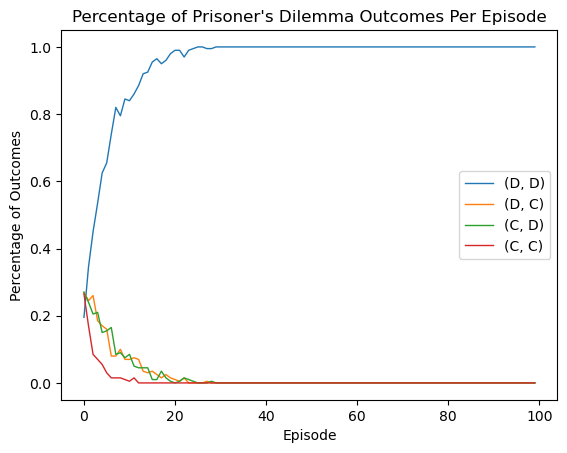

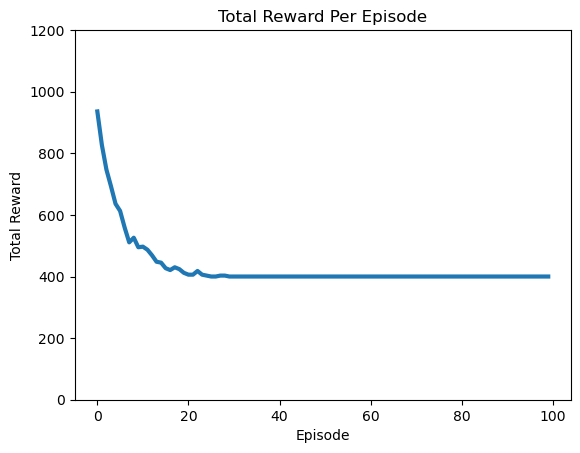

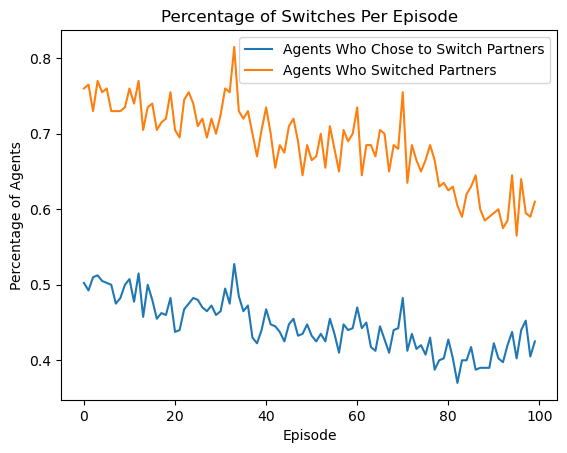

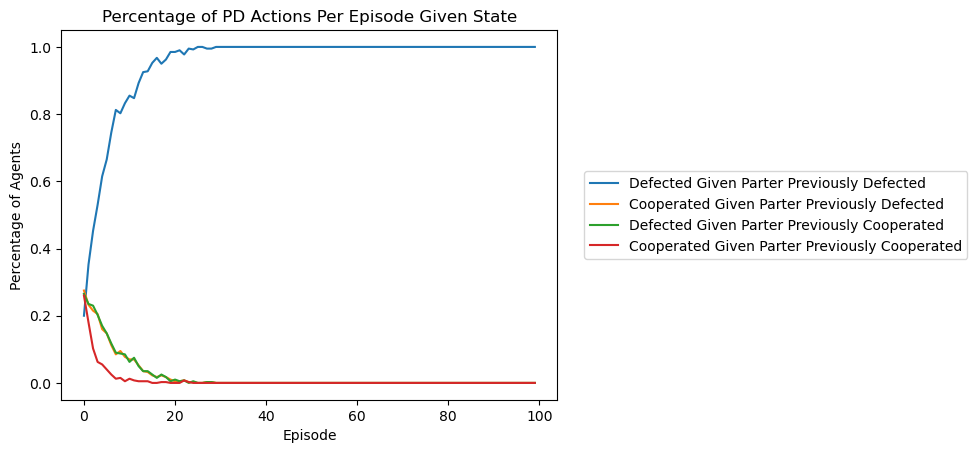

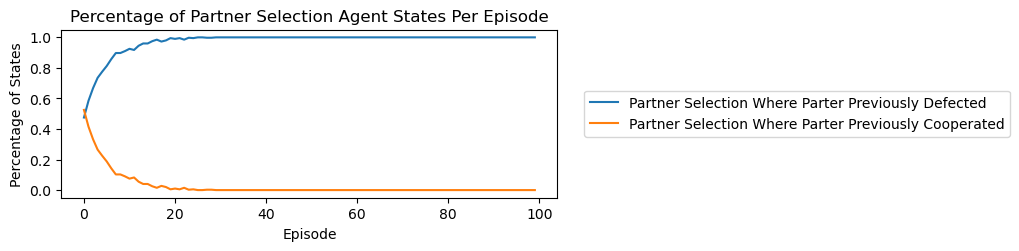

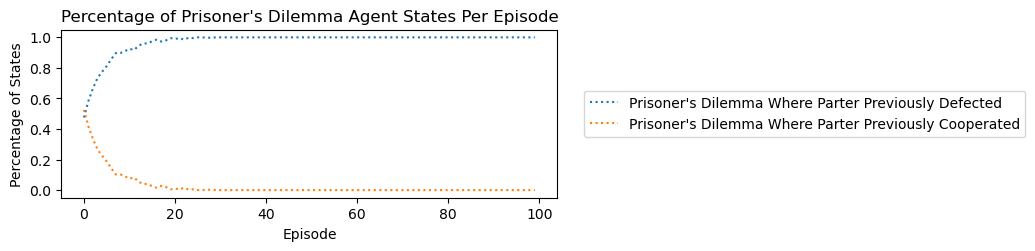

Agent 0) Tag: 2, PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[ 4.83744504 50.25680232]
 [ 2.9395009   1.78276586]]
[[50.76962283  2.17133335]
 [ 4.01126332  1.35647665]]
Agent 1) Tag: 2, PS-Strategy: Always-Leave, PD-Strategy: Always-Defect
[[37.01963172 36.87866325]
 [ 1.66295341  0.65746682]]
[[37.68139074  3.03263785]
 [ 3.10114783  0.73679449]]
Agent 2) Tag: 1, PS-Strategy: Out-For-Tat, PD-Strategy: Always-Defect
[[49.77438761  8.34717914]
 [ 1.76641992  2.48498554]]
[[50.28720813  1.99696959]
 [ 4.00363912  0.71702027]]
Agent 3) Tag: 3, PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[14.75896544 48.23632885]
 [ 3.1165755   2.17773137]]
[[48.74914936  2.47425271]
 [ 4.96832135  2.44533388]]
Agent 4) Tag: 1, PS-Strategy: Reverse-OFT, PD-Strategy: Always-Defect
[[31.51209815 39.8026774 ]
 [ 1.49786142  1.31560162]]
[[40.31549816  3.18241922]
 [ 3.27228445  1.02450142]]
Agent 5) Tag: 1, PS-Strategy: Always-Leave, PD-Strategy: Always-Defect
[[39.99724703 39.01329488]
 

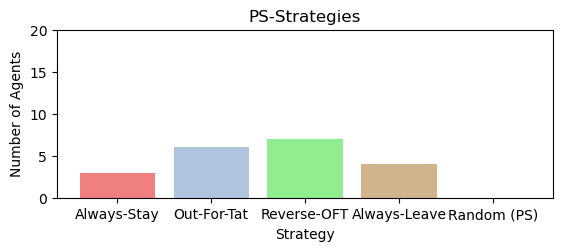

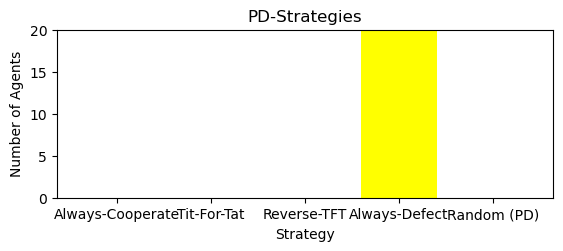

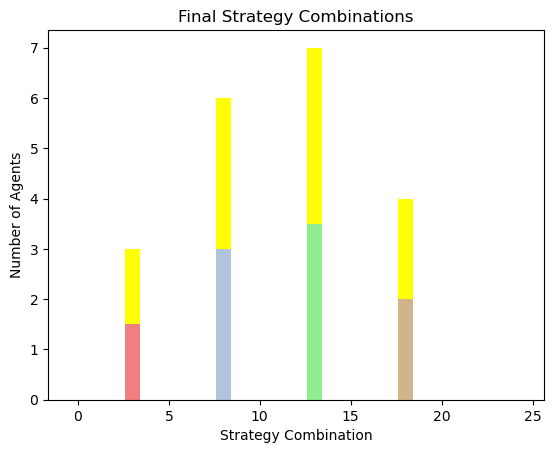

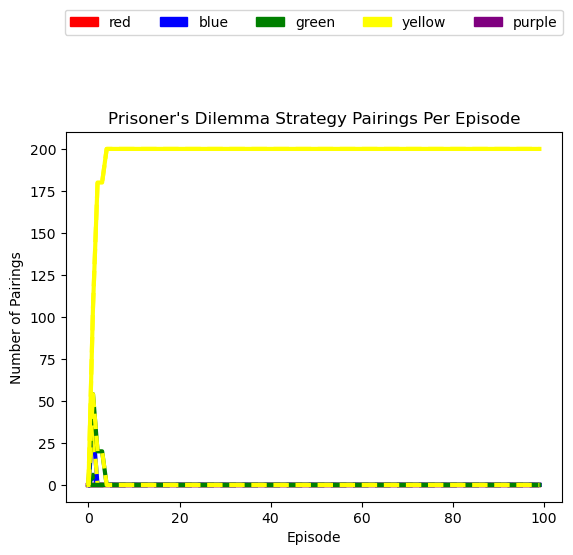

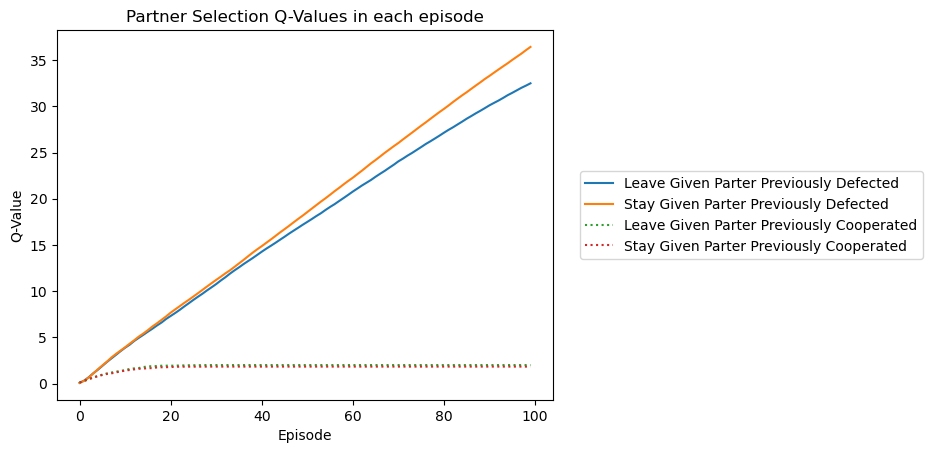

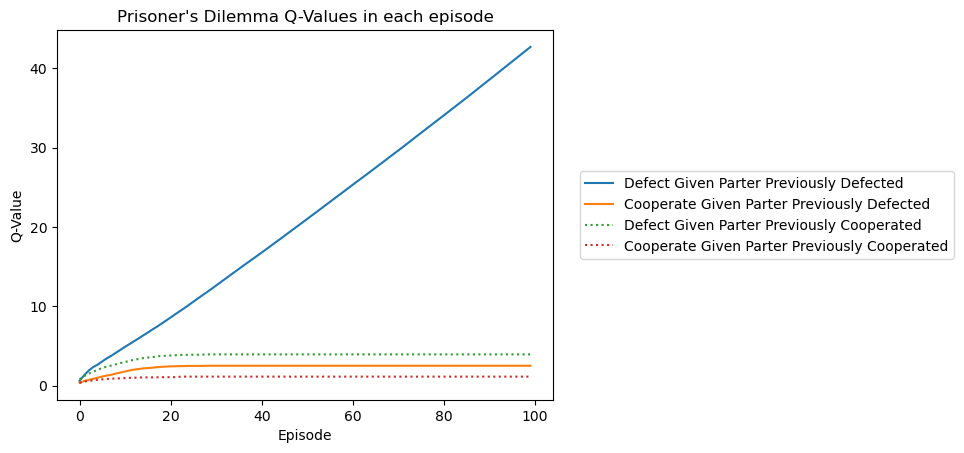

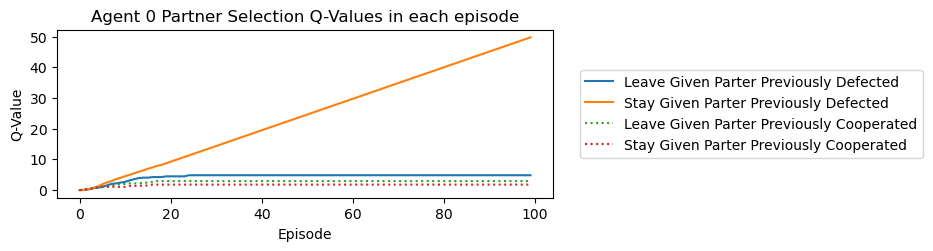

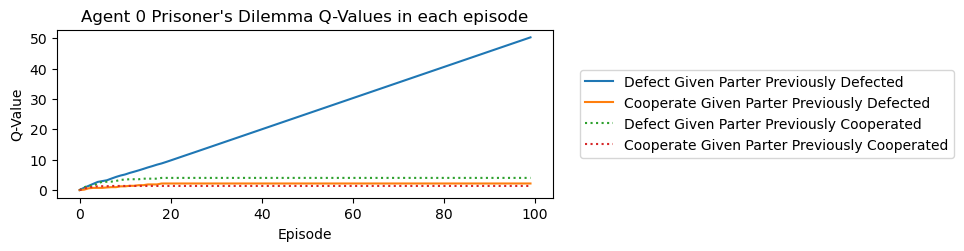

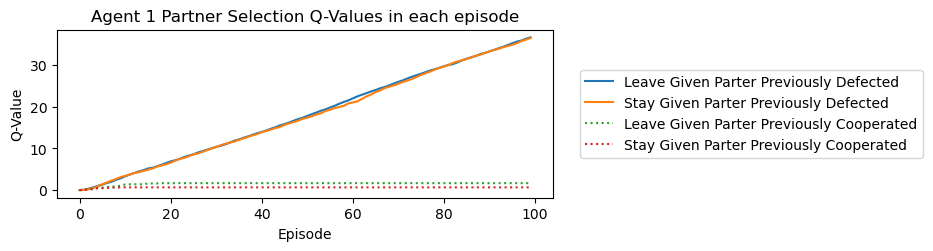

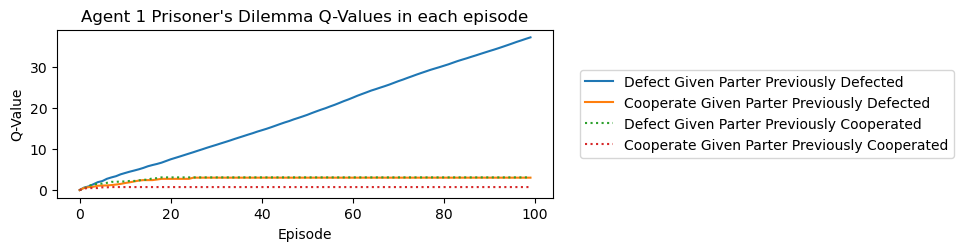

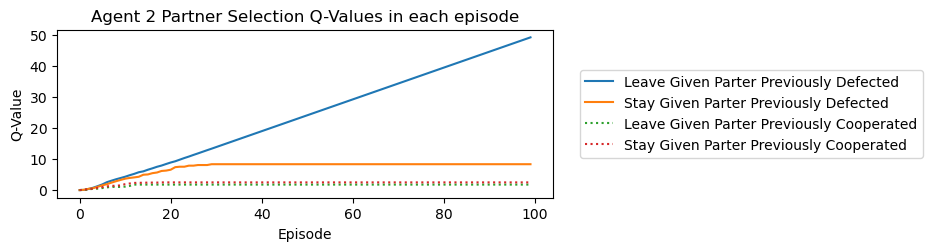

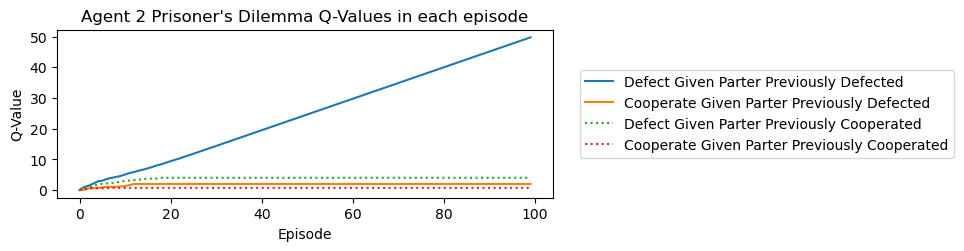

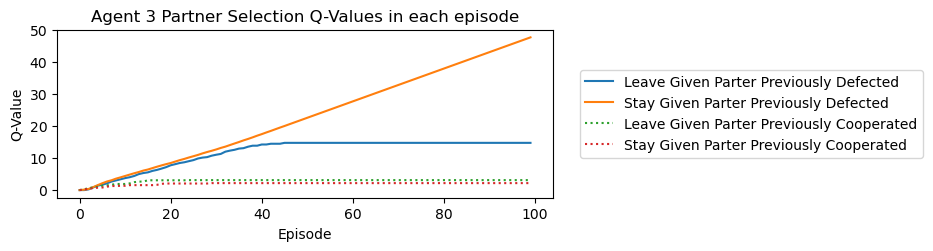

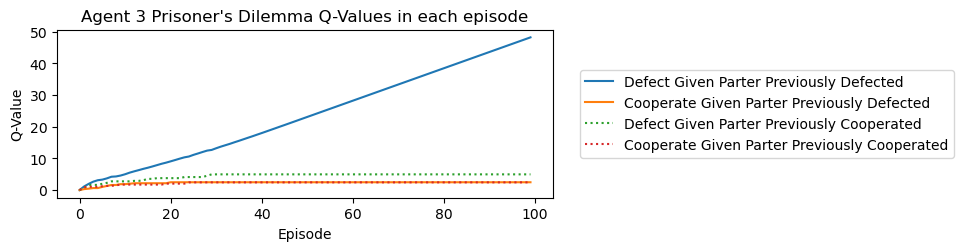

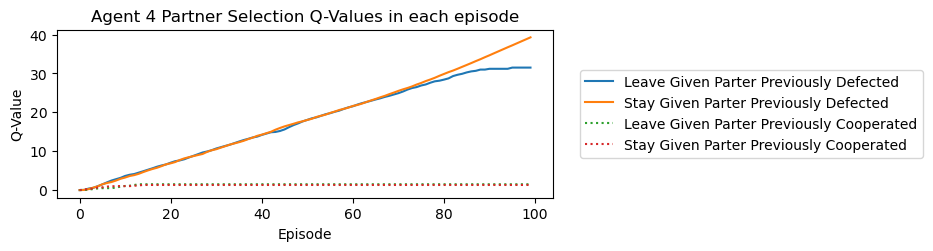

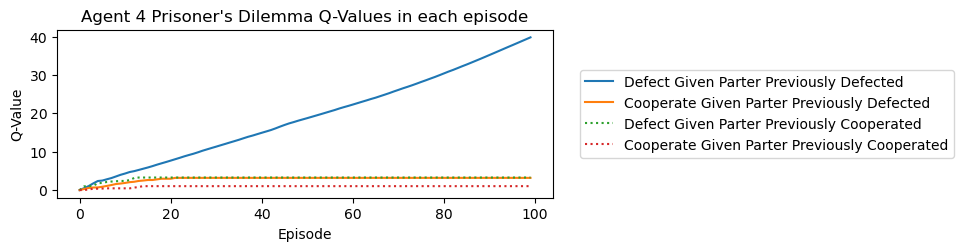

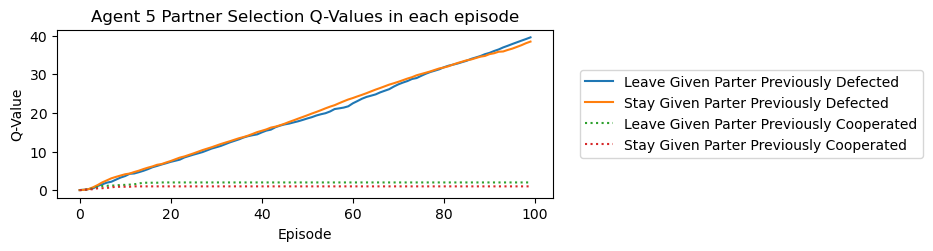

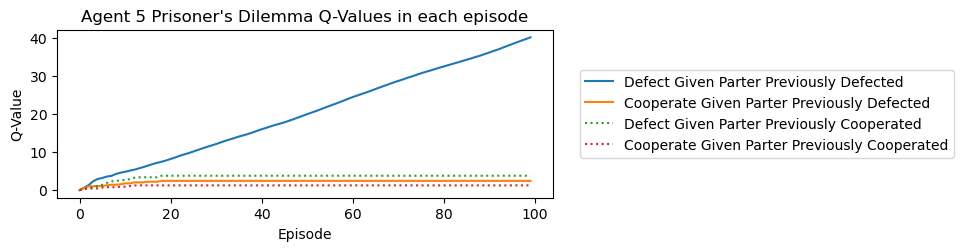

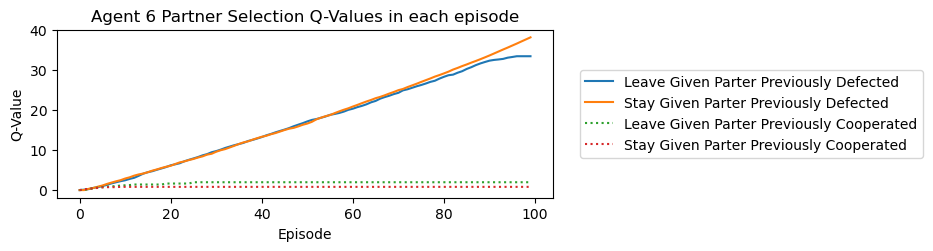

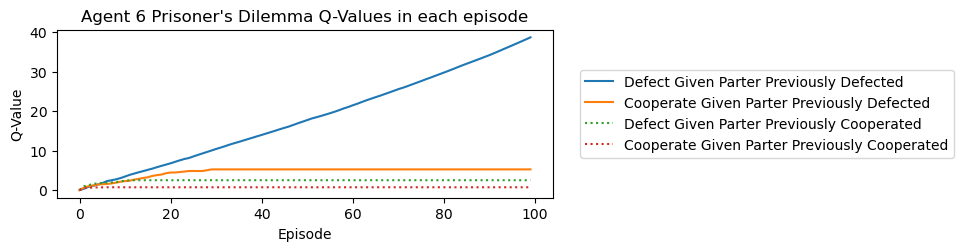

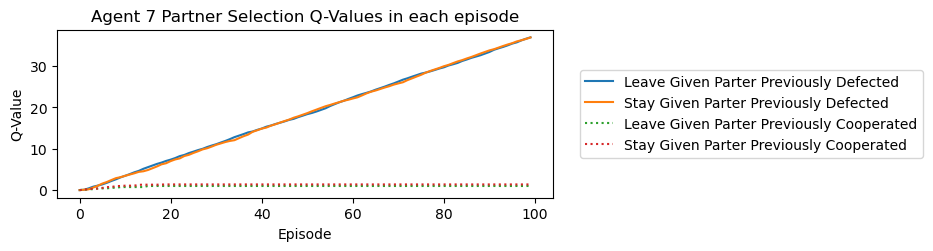

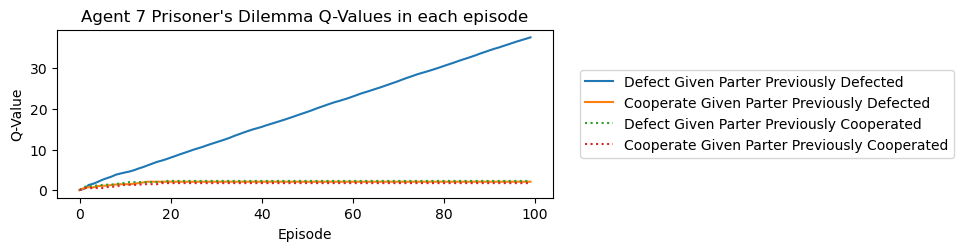

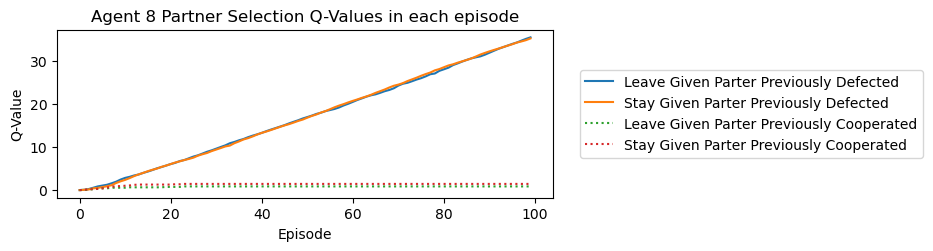

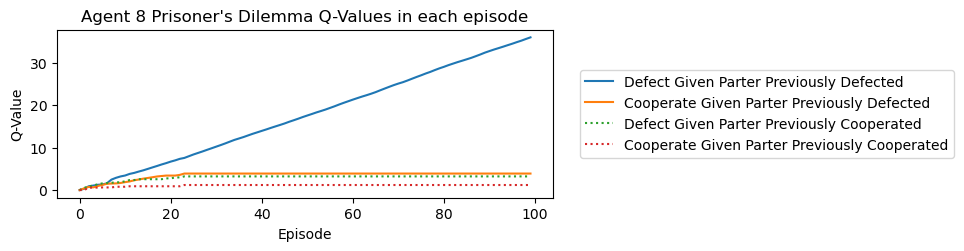

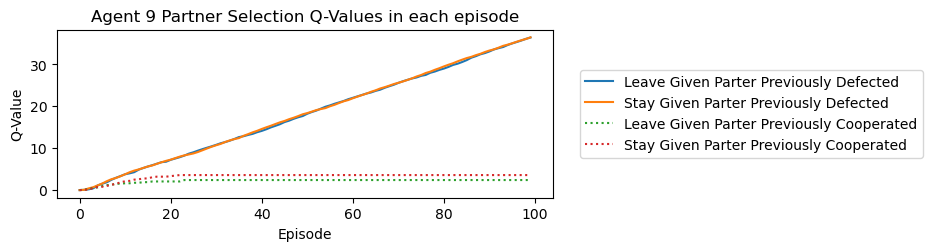

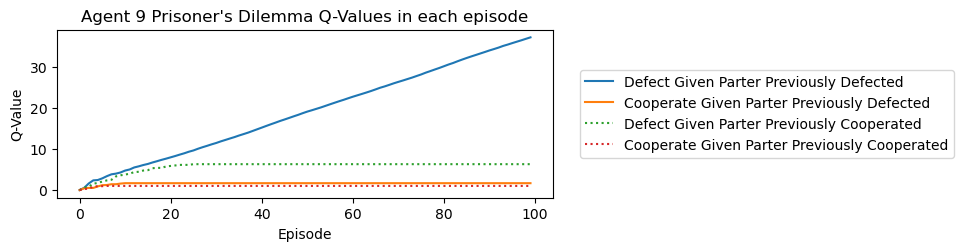

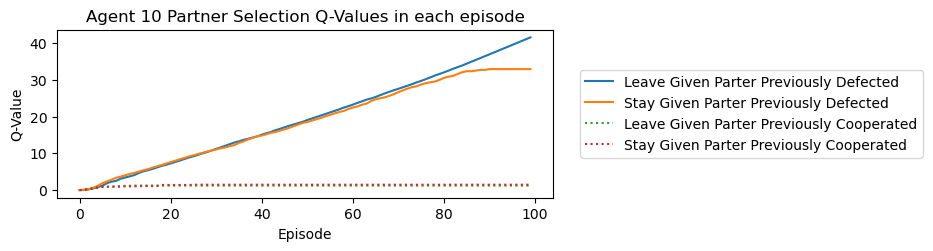

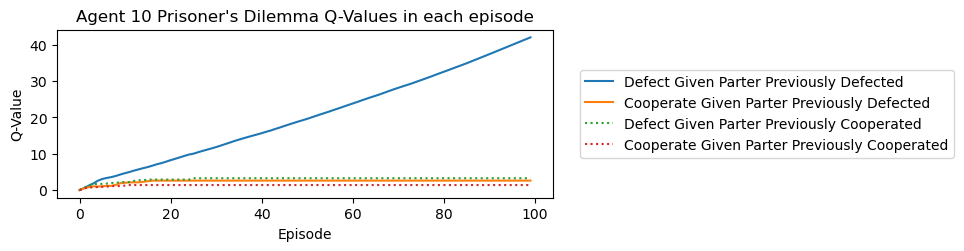

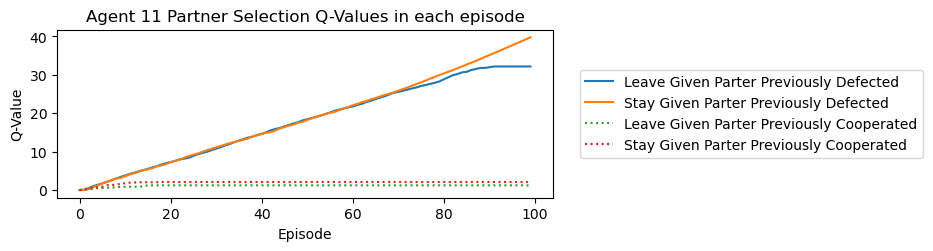

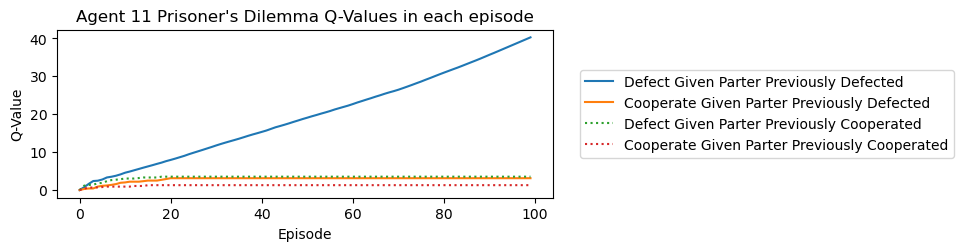

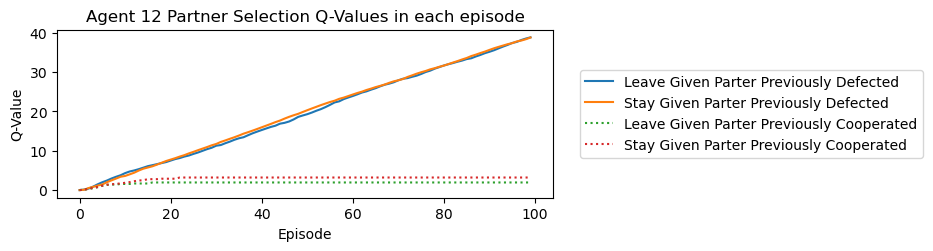

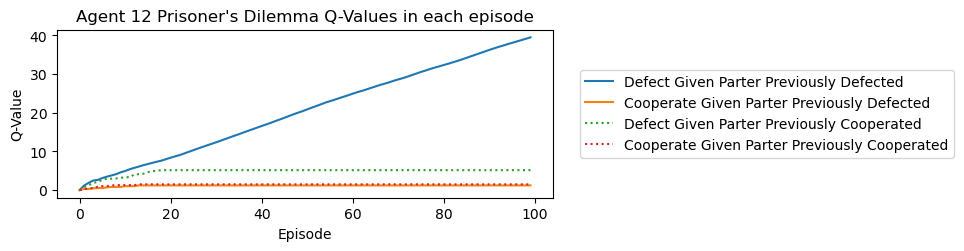

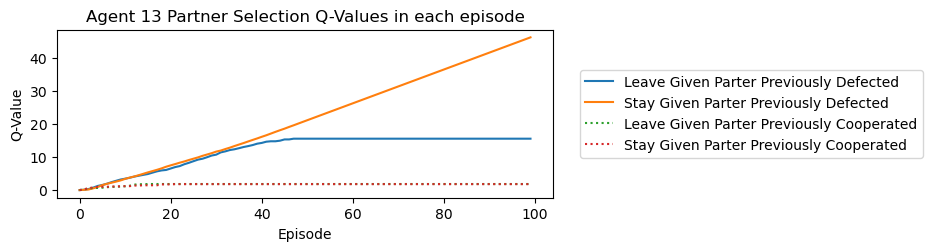

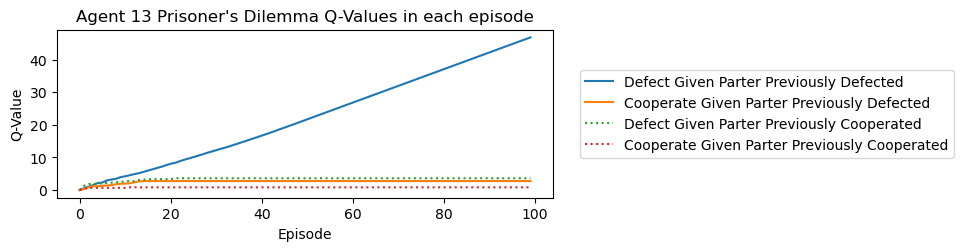

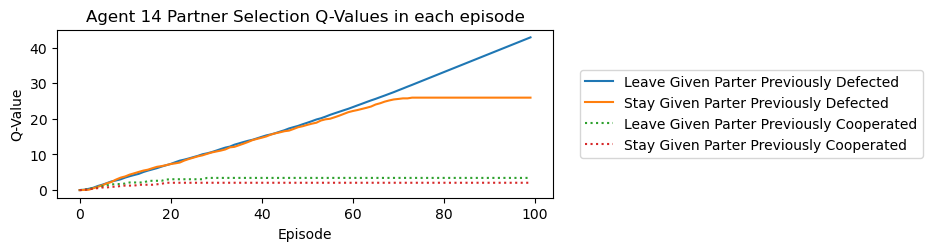

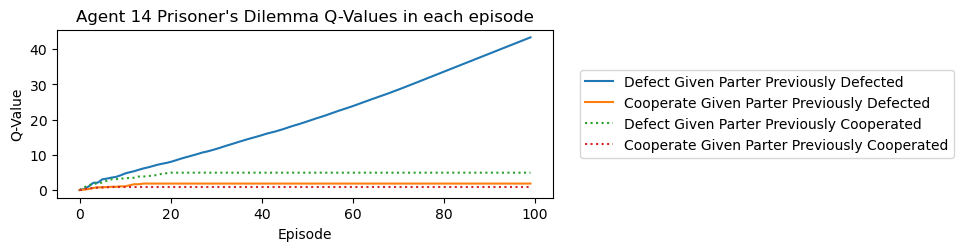

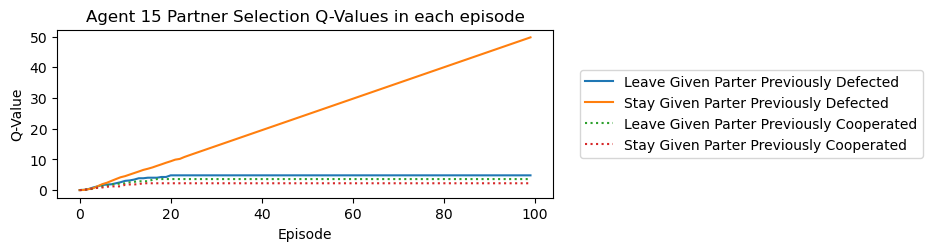

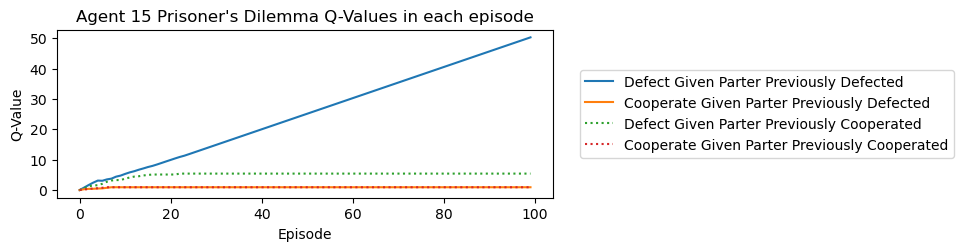

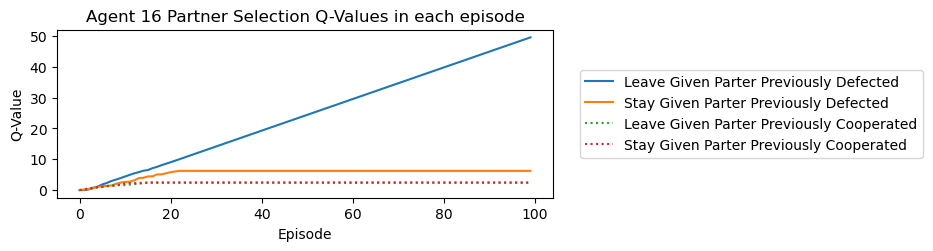

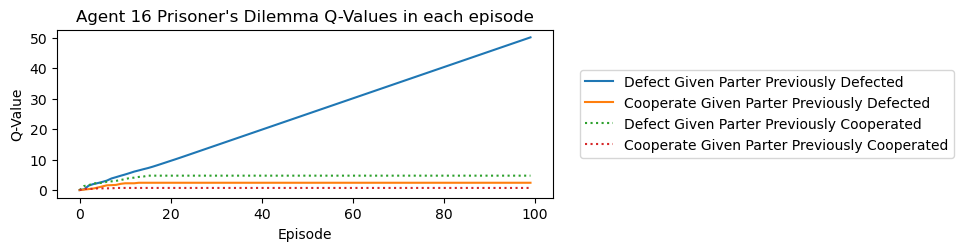

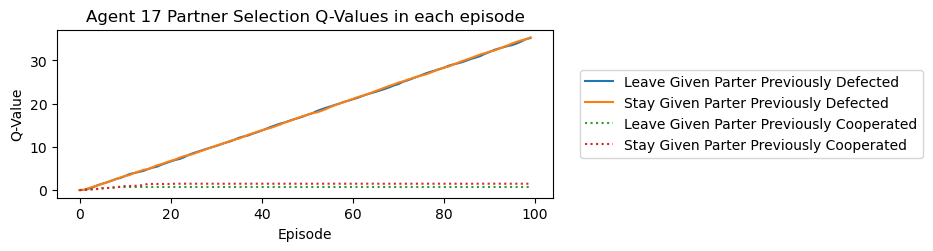

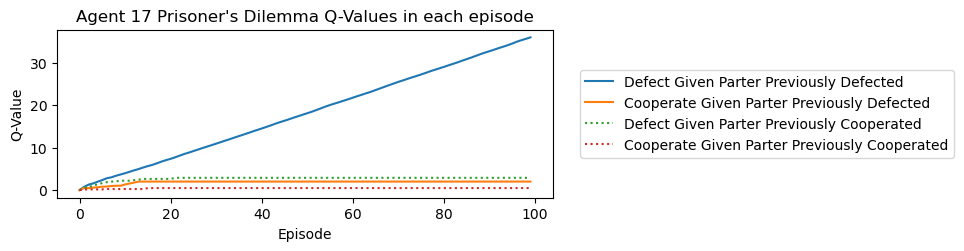

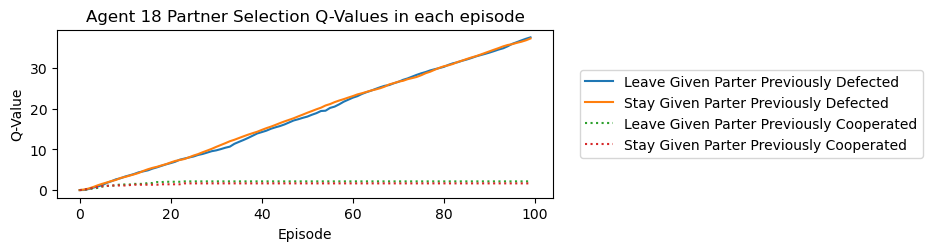

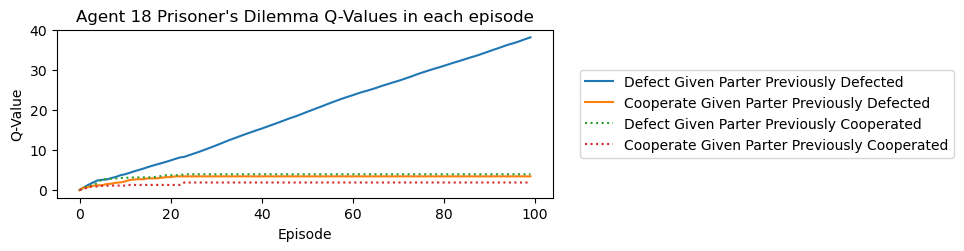

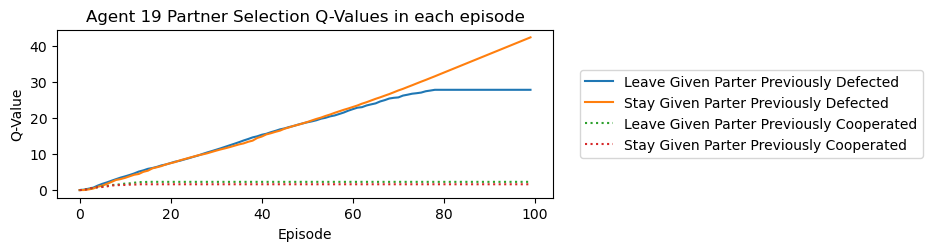

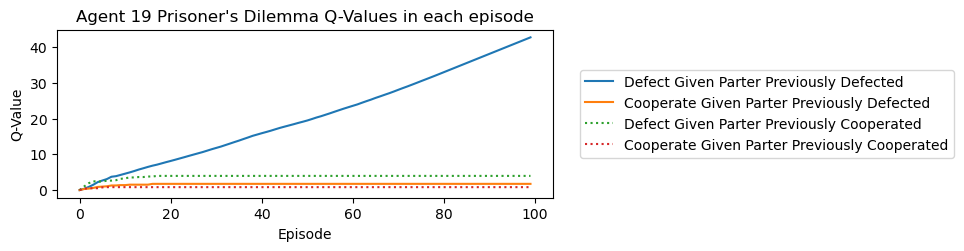

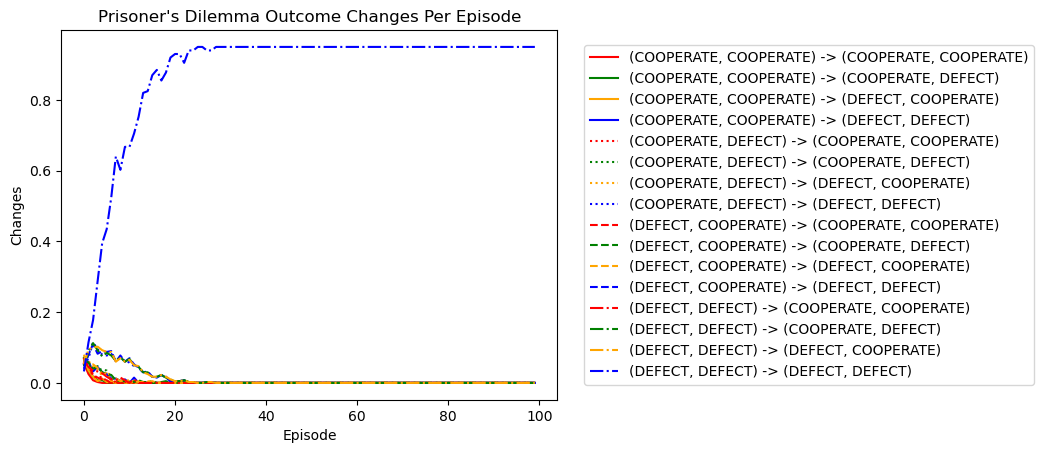

In [93]:
sdoo(20, 20, 100, 0.05, 1, 1)